# Text Classification: Building a model with K-Train

## About this Project

The goal of building an inference model for predicting whether or not a document is about "healthy living." We will use the K-Train library to do this. we will explore ways to tweak and improve the model with hyperparameters

## Imports

We're going to be using Google's Tensorflow package:
https://www.tensorflow.org/tutorials

We're using an API wrapper for Tensorflow called **ktrain**. It abstracts the whole deep learning process into a workflow:
https://github.com/amaiya/ktrain

In [5]:
import os

!pip install -U tf_keras # Keras 2
os.environ["TF_USE_LEGACY_KERAS"] = "1"
print("OS Environment Set ")
!pip install tensorflow==2.15.1
import tensorflow as tf
print("tensorflow version", tf.__version__)


try:
  print("Importing Ktrain")
  import ktrain
except:
  print("------In Except while installing Ktrain------")
  !pip install ktrain
  print("Now Killing Process")
  #os.kill(os.getpid(), 9)
  print("Process Killed")
import ktrain
import pandas as pd
import numpy as np

from tf_keras.optimizers import Adam

print("All files loaded successfully...!!!")

OS Environment Set 
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.8 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found e

## Mount Google Drive

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Set your google colab runtime to use GPU, a must for deep learning!

Runtime > Change Runtime Type > GPU

The following code snippet will show you GPU information for your runtime.

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Oct  7 18:13:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Load the data

The data file should be in your Google Drive from Lab 1.

In [4]:
reviews = pd.read_json("/content/drive/MyDrive/MSDS/ColabNotebooks/marketing_text_analytics/master_files/text_classification/news_category_trainingdata.json")

## Inspect the data

In [5]:
reviews.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


## Prepare the data

Most machine learning tools in Python accept one field/column/string. So we have to merge our two text column. Let's separate it with a space.

In [6]:
reviews['combined_text'] = reviews['headline'] + ' ' + reviews['short_description']

The first thing we need to do is prepare the data. Specifically, we have a categorical column that we want to turn into a "is this article healthy living?" column. That is, when an article is about healthy living, it should have a 1, when it's anything else, it should be a 0.

In [7]:
reviews[reviews['category'].str.contains("HEALTHY LIVING")]

,category,headline,authors,link,short_description,date,combined_text
7578,HEALTHY LIVING,To The People Who Say ‘I’m Tired’ When Someone...,"The Mighty, ContributorWe face disability, dis...",https://www.huffingtonpost.com/entry/to-the-pe...,"When you feel like this, it’s important to kno...",2018-01-16,To The People Who Say ‘I’m Tired’ When Someone...
7693,HEALTHY LIVING,Eating Shake Shack Made Me Feel Healthier Than...,"Colleen Werner, ContributorCampus Editor-at-Large",https://www.huffingtonpost.com/entry/eating-sh...,I can vividly remember the first time I felt f...,2018-01-12,Eating Shake Shack Made Me Feel Healthier Than...
7747,HEALTHY LIVING,How To Stay Updated On The News Without Losing...,Lindsay Holmes,https://www.huffingtonpost.com/entry/anxiety-f...,Because it's only becoming more of a struggle.,2018-01-12,How To Stay Updated On The News Without Losing...
7927,HEALTHY LIVING,27 Perfect Tweets About Whole30 That Will Make...,Lindsay Holmes,https://www.huffingtonpost.com/entry/tweets-ab...,"""The only Whole30 I want to participate in is ...",2018-01-10,27 Perfect Tweets About Whole30 That Will Make...
7934,HEALTHY LIVING,The Real Reason Your Hands Are Always Cold,"Refinery29, ContributorThe #1 new-media brand ...",https://www.huffingtonpost.com/entry/the-real-...,"Essentially, your hands are kept warm thanks t...",2018-01-10,The Real Reason Your Hands Are Always Cold Ess...
...,...,...,...,...,...,...,...
124913,HEALTHY LIVING,Why You Need Both a 'Bouncer' and a 'Bartender...,"Elizabeth Grace Saunders, ContributorFounder, ...",https://www.huffingtonpost.com/entry/happy-hea...,Instead of judging whether you made the right ...,2014-04-18,Why You Need Both a 'Bouncer' and a 'Bartender...
124914,HEALTHY LIVING,How Video Games Can Improve Dialogue on Mental...,"Mona Shattell, Contributornurse researcher",https://www.huffingtonpost.com/entry/mental-il...,While there are strong arguments for the games...,2014-04-18,How Video Games Can Improve Dialogue on Mental...
124925,HEALTHY LIVING,Wake-Up Calls Inspired My Change From Overdriv...,"Jane Shure, ContributorLeadership Coach, Psych...",https://www.huffingtonpost.com/entry/wake-up-c...,My wake-up call marching orders were clear: No...,2014-04-18,Wake-Up Calls Inspired My Change From Overdriv...
124950,HEALTHY LIVING,Loving a Narcissist Without Losing Yourself,"Nancy Colier, ContributorPsychotherapist, inte...",https://www.huffingtonpost.com/entry/narcissis...,It is very difficult for some people to see an...,2014-04-18,Loving a Narcissist Without Losing Yourself It...


In [8]:
reviews['healthy'] = np.where((reviews['category'] == 'HEALTHY LIVING'), 1, 0)

In [9]:
reviews[reviews['healthy'] == 1].count()

,0
category,6694
headline,6694
authors,6694
link,6694
short_description,6694
date,6694
combined_text,6694
healthy,6694


In [10]:
reviews['healthy'].describe()

,healthy
count,200853.000000
mean,0.033328
std,0.179492
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


## Balance the data

To create a balanced data set that includes all of the health living articles, set sample_amount to the total number of those articles.

In Lab 1, you balanced the data for the full set of healthy living articles. In the interest of getting through Lab 2 more quickly (in terms of training time for the model), we will use a smaller sample, of just 1000 articles per class. After completing the lab, consider increasing the sample size to see if you can get improvements on the model performance. Of course, be prepared for longer training times when you do that.

In [11]:
# We have replaced the sample count with a smaller number in order to expedite
# the completion of the lab. We want to use the full balanced document set which
# is determined by this commented line:
#sample_amount =  len(reviews[reviews["healthy"] == 1]) # the total number of healthy living articles

sample_amount =  len(reviews[reviews["healthy"] == 1])
print("Sample Amount: ", sample_amount )

healthy = reviews[reviews['healthy'] == 1].sample(n=sample_amount)
not_healthy = reviews[reviews['healthy'] == 0].sample(n=sample_amount)

In [12]:
review_sample = pd.concat([healthy,not_healthy])

In [13]:
review_sample.describe()

,date,healthy
count,13388,13388.000000
mean,2015-06-20 06:52:42.234836992,0.500000
min,2012-01-28 00:00:00,0.000000
25%,2014-07-05 00:00:00,0.000000
50%,2015-05-18 00:00:00,0.500000
75%,2016-09-30 00:00:00,1.000000
max,2018-05-25 00:00:00,1.000000
std,NaN,0.500019


# On to Lab 2: Test, Tune and Save Models

Here, you will tune and train a predictor model for classifying healthy-living articles. After completing this lab, complete the Lab Quiz by entering your precision and recall values from the validation report for both the negative and positive classes.

In [14]:
target_names = ['NOT HEALTHY LIVING','HEALTHY LIVING']

---

### Experimenting with different transformers

For purposes of this lab, we are using the **distilbert-base-uncased** transformer model. Other models you might try for your final project include:

 * roberta-base
 * bert-base-uncased
 * distilroberta-base

See all the models here: https://huggingface.co/transformers/pretrained_models.html

Some work, some dont, try at your own risk.

---

In [15]:
 train, val, preprocess = ktrain.text.texts_from_df(
    review_sample,
    "combined_text",
    label_columns=["healthy"],
    val_df=None,
    max_features=30000,
    maxlen=512,
    val_pct=0.1,
    ngram_range=1,
    preprocess_mode="distilbert", # Try roberta, bert
    verbose=1
)

['not_healthy', 'healthy']
        not_healthy  healthy
87182           1.0      0.0
168594          1.0      0.0
862             1.0      0.0
19617           1.0      0.0
83109           1.0      0.0
['not_healthy', 'healthy']
        not_healthy  healthy
189341          1.0      0.0
180691          1.0      0.0
120544          1.0      0.0
122327          0.0      1.0
32854           0.0      1.0


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

preprocessing train...
language: en
train sequence lengths:
	mean : 29
	95percentile : 58
	99percentile : 70


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 29
	95percentile : 58
	99percentile : 69


In [16]:
optimizer = Adam(learning_rate=0.001)
print('optimizer created successfully..!')


model = preprocess.get_classifier()
print('Model created successfully..!')

learner = ktrain.get_learner(model, train_data=train, val_data=val, batch_size=16)
print('Learner created successfully..!')

optimizer created successfully..!
Model created successfully..!
Learner created successfully..!


In [17]:
learner.lr_find(max_epochs=6)

simulating training for different learning rates... this may take a few moments...
Epoch 1/6
753/753 [==============================] - 694s 858ms/step - loss: 0.6585 - accuracy: 0.6125
Epoch 2/6
753/753 [==============================] - 651s 865ms/step - loss: 0.3687 - accuracy: 0.8518
Epoch 3/6
753/753 [==============================] - 649s 861ms/step - loss: 0.4698 - accuracy: 0.7453
Epoch 4/6
753/753 [==============================] - 644s 855ms/step - loss: 0.6974 - accuracy: 0.5078
Epoch 5/6
753/753 [==============================] - 69s 91ms/step - loss: 8.0457 - accuracy: 0.5112


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


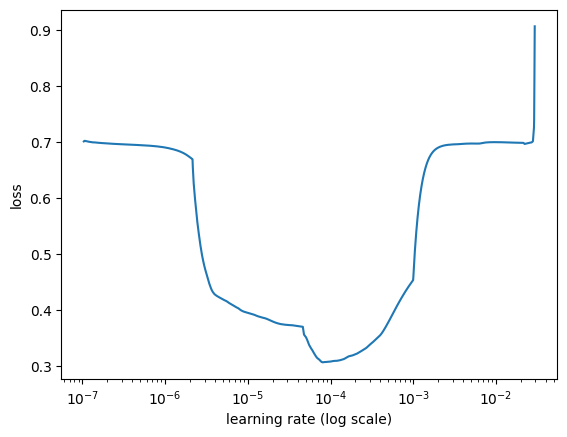

In [18]:
learner.lr_plot()

Now, use the tuned learner to train the best model.

Here, we define a limit of 10 epochs, but in reality, this should stop much sooner due to early stopping.

In [19]:
history=learner.autofit(
    1e-4,
    checkpoint_folder='checkpoint',
    epochs=10,
    early_stopping=True
)



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/10
754/754 [==============================] - 700s 898ms/step - loss: 0.3861 - accuracy: 0.8411 - val_loss: 0.3362 - val_accuracy: 0.8671
Epoch 2/10
754/754 [==============================] - 670s 889ms/step - loss: 0.2374 - accuracy: 0.9100 - val_loss: 0.3499 - val_accuracy: 0.8603
Epoch 2: early stopping
Restoring model weights from the end of the best epoch: 1.
Weights from best epoch have been loaded into model.


Get the predictor

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=preprocess)

This code to save the predictor and reload it later. Note, the saved models can be quite large.

In [ ]:
predictor.save("drive/MyDrive/MSDSTextClassification_Lab2.healthy_living")

In [22]:
validation = learner.validate(val_data=val, print_report=True)

42/42 [==============================] - 16s 291ms/step
              precision    recall  f1-score   support

           0       0.91      0.83      0.86       682
           1       0.83      0.91      0.87       657

    accuracy                           0.87      1339
   macro avg       0.87      0.87      0.87      1339
weighted avg       0.87      0.87      0.87      1339



# Inspecting the drivers of prediction

No matter what the supervised machine learning model, you always want to peak under the hood to see what features are driving prediction. That is, what words sway the outcome of the prediction. It's harder to inspect a neural network. Because all of the layers of a neural network aren't really interpretable to the human eye.

Currently, the best practice I've found is a little tool Explainable AI:
https://alvinntnu.github.io/python-notes/nlp/ktrain-tutorial-explaining-predictions.html

In [1]:
!pip3 install -q git+https://github.com/amaiya/eli5@tfkeras_0_10_1

  Preparing metadata (setup.py) ... done


Let's go ahead and make a little set of test documents to check out

In [10]:
test_docs = [
'Stress May Be Your Heart’s Worst Enemy Psychological stress activates the fear center in the brain, setting into motion a cascade of reactions that can lead to heart attacks and strokes.',
'Exercising to Slim Down? Try Getting Bigger. It’s high time for women to reclaim the real strength behind exercise.',
'What Are Your Food Resolutions for the New Year? Join us for the Eat Well Challenge starting in January.',
'Why We All Need to Have More Fun. Prioritizing fun may feel impossible right now. But this four-step plan will help you rediscover how to feel more alive.',
'Cuomo Will Not Be Prosecuted in Groping Case, Albany D.A. Says. The district attorney described the woman who said former Gov. Andrew Cuomo had groped her as “credible,” but added that proving her allegation would be difficult.',
'A Film Captures Jewish Life in a Polish Town Before the Nazis Arrived. A documentary based on a home movie shot by an American in 1938 provides a look at the vibrancy of a Jewish community in Europe just before the Holocaust.'
             ]

In [9]:
loaded_predictor = ktrain.load_predictor("drive/MyDrive/MSDSTextClassification_Lab2.healthy_living")


In [11]:
for i, text in enumerate(test_docs):
  probs = loaded_predictor.predict(text, return_proba=True)
  print("---------------------------")
  print('The probability this is healthy is %s' % probs[1])
  print(text)

---------------------------
The probability this is healthy is 0.8991439
Stress May Be Your Heart’s Worst Enemy Psychological stress activates the fear center in the brain, setting into motion a cascade of reactions that can lead to heart attacks and strokes.
---------------------------
The probability this is healthy is 0.90776646
Exercising to Slim Down? Try Getting Bigger. It’s high time for women to reclaim the real strength behind exercise.
---------------------------
The probability this is healthy is 0.8697988
What Are Your Food Resolutions for the New Year? Join us for the Eat Well Challenge starting in January.
---------------------------
The probability this is healthy is 0.8435418
Why We All Need to Have More Fun. Prioritizing fun may feel impossible right now. But this four-step plan will help you rediscover how to feel more alive.
---------------------------
The probability this is healthy is 0.008445444
Cuomo Will Not Be Prosecuted in Groping Case, Albany D.A. Says. The d

*These* are pretty obvious examples, but it works exactly as expected!

In [17]:
prob = loaded_predictor.predict('Diversity is the key to a healthy society. Here is what we need to do to make america a more equitable place to live for all.', return_proba=True)
print("---------------------------")
print('The probability this is healthy is %s' % prob[1])


---------------------------
The probability this is healthy is 0.88542897


But you can see, this algorithm is far from perfect. Here you can see that it's probably got too high of an emphasis on the word "healthy."